In [51]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import comb
from sklearn.metrics import cohen_kappa_score, confusion_matrix
from matplotlib.colors import LogNorm, Normalize
import seaborn as sns

In [100]:
def load_csv_files(true_file, pred_file):
    true_df = pd.read_csv(true_file, index_col=0)
    pred_df = pd.read_csv(pred_file, index_col=0)
    return true_df, pred_df

def calculate_error(true_val, pred_val):
    return (true_val - pred_val) ** 2

def compute_rmse(true_values, pred_values):
    sum_squared_error = sum(calculate_error(t, p) for t, p in zip(true_values, pred_values))
    mse = sum_squared_error / len(true_values) if true_values else 0
    return np.sqrt(mse)

In [101]:
def process_category(true_df, pred_df):
    category_true_values = []
    category_pred_values = []

    for i in range(true_df.shape[0]):
        for j in range(i + 1, true_df.shape[1]):
            image_1 = true_df.index[i]
            image_2 = true_df.columns[j]

            if image_1.split('_')[1] != image_2.split('_')[1]:
                true_val = true_df.iloc[i, j]
                pred_val = pred_df.iloc[i, j]
                category_true_values.append(true_val)
                category_pred_values.append(pred_val)

    return category_true_values, category_pred_values

def traverse_folders(test_folder, true_csv, rmse_for, websites=None):
    true_values = []
    pred_values = []
    category_rmses = {}

    website_list = websites if websites else os.listdir(test_folder)

    for website in website_list:
        try:
            website_path = os.path.join(test_folder, website)
            if not os.path.isdir(website_path):
                continue

            for category in os.listdir(website_path):
                category_path = os.path.join(website_path, category)
                if not os.path.isdir(category_path):
                    continue

                true_file = os.path.join(category_path, true_csv)
                pred_file = os.path.join(category_path, rmse_for)

                if os.path.exists(true_file) and os.path.exists(pred_file):
                    true_df, pred_df = load_csv_files(true_file, pred_file)
                    cat_true_vals, cat_pred_vals = process_category(true_df, pred_df)

                    if cat_true_vals:
                        rmse = compute_rmse(cat_true_vals, cat_pred_vals)
                        true_values.extend(cat_true_vals)
                        pred_values.extend(cat_pred_vals)
                        category_rmses[category] = rmse / 4
        except Exception as e:
            print(category_path)
            print(e)

    return true_values, pred_values, category_rmses

In [103]:
def calculate_rmse(true_csv, rmse_for, test_folder, overall=True, websites=None):
    true_values, pred_values, category_rmses = traverse_folders(test_folder, true_csv, rmse_for, websites)

    if overall:
        overall_rmse = compute_rmse(true_values, pred_values)
        return overall_rmse / 4
    else:
        return pd.DataFrame(list(category_rmses.items()), columns=['Category', 'RMSE'])

In [104]:
prompt_eng_websites = ['aajtak.in', 'francetvinfo.fr', 'news.yahoo.com', 'www.nypost.com', 'www.ndtv.com']
true_csv = 'true_labels.csv'
data_dir =  '../../data'
models = ['gpt', 'claude', 'gemini', 'llama']

#### NRMSE for prompt design (subset of 5 websites)

##### Base prompt - on 5 websites

In [106]:
pred_csv = {x: f'{x}_pred_labels_0.csv' for x in models}

base_prompt_nrmse = {}
for model, csv in pred_csv.items():
    base_prompt_nrmse[model] = calculate_rmse(true_csv, pred_csv[model], data_dir, overall=True, websites=prompt_eng_websites)

base_prompt_nrmse


{'gpt': 0.18787190583127195,
 'claude': 0.23378755431664808,
 'gemini': 0.2541794938710003,
 'llama': 0.2315330478763984}

##### Metric-Driven prompt (prompt#1 in 'image to output/prompts.py') - on 5 websites

In [105]:
pred_csv = {x: f'{x}_pred_labels_1.csv' for x in models}

metric_prompt_nrmse = {}
for model, csv in pred_csv.items():
    metric_prompt_nrmse[model] = calculate_rmse(true_csv, pred_csv[model], data_dir, overall=True, websites=prompt_eng_websites)

metric_prompt_nrmse

{'gpt': 0.17617967672109122,
 'claude': 0.19071059934879975,
 'gemini': 0.19104179021944256,
 'llama': 0.2145755112628546}

##### Dynamic Few shot on LLaMA 3.1 (using metric driven prompt) - on 29 websites

In [27]:
few_shot_llama = calculate_rmse(true_csv, 'llama_pred_labels_fewshot.csv', data_dir, overall=True)
few_shot_llama

0.24567456386745803

### Plotting Prompt design results

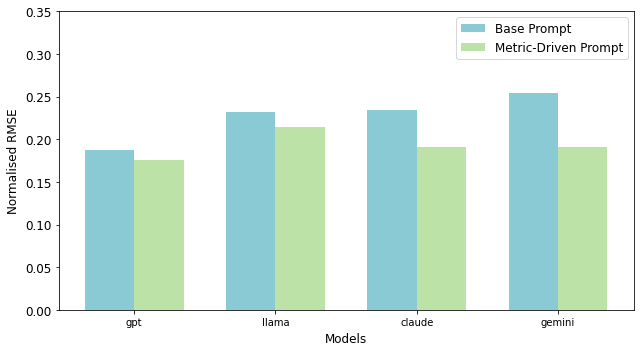

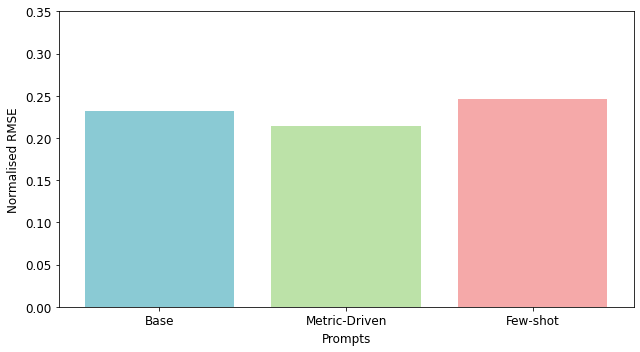

In [47]:
model_names_mapping = {
    'gpt': 'GPT-4',
    'claude': 'Claude 3.5',
    'gemini': 'Gemini 1.5',
    'llama': 'Llama 3.1'
}

sorted_models = sorted(base_prompt_nrmse, key=base_prompt_nrmse.get)

base_rmse_sorted = [base_prompt_nrmse[model] for model in sorted_models]
metric_prompt_rmse_sorted = [metric_prompt_nrmse[model] for model in sorted_models]
sorted_model_names = [model_names_mapping[model] for model in sorted_models]

plt.figure(figsize=(9, 5))

bar_width = 0.35
index = np.arange(len(sorted_models))

bars1 = plt.bar(index, base_rmse_sorted, bar_width, label="Base Prompt", color="#59B4C3", zorder=2, alpha=0.7)
bars2 = plt.bar(index + bar_width, metric_prompt_rmse_sorted, bar_width, label="Metric-Driven Prompt", color="#A0D683", zorder=2, alpha=0.7)

plt.ylim(0, 0.35)

plt.xlabel("Models", fontsize=12, labelpad=5)
plt.ylabel("Normalised RMSE", fontsize=12, labelpad=5)
plt.xticks(index + bar_width / 2, sorted_models, fontsize=10)
plt.yticks(fontsize=12)
plt.legend(loc="best", fontsize=12)

plt.tight_layout()
plt.show()

plt.figure(figsize=(9, 5))

llama_comparison = ['Base', 'Metric-Driven', 'Few-shot']
llama_rmse = [
    base_prompt_nrmse['llama'],
    metric_prompt_nrmse['llama'],
    few_shot_llama
]

bars3 = plt.bar(llama_comparison, llama_rmse, color=["#59B4C3", "#A0D683", "#F28585"], zorder=2, alpha=0.7)

plt.ylim(0, 0.35)

plt.xlabel("Prompts", fontsize=12, labelpad=5)
plt.ylabel("Normalised RMSE", fontsize=12, labelpad=5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

In [39]:
def extract_comparisons(df, threshold=1):
    num_useful_comparisons = 0
    total_comparisons = 0

    columns = df.columns
    for i in range(len(columns)):
        for j in range(i+1, len(columns)):
            # Ignore comparisons from the same article (i.e. same prefix img_1_*)
            if columns[i].split('_')[1] != columns[j].split('_')[1]:
                value = df.iloc[i, j]
                total_comparisons += 1
                if value >= threshold:
                    num_useful_comparisons += 1

    return num_useful_comparisons, total_comparisons

In [33]:
X_vals = list(range(0, 50)) # range of pesudo values for # imgs in client cache from same website-category
p_list = []
bytes_saved_list = []
my_image_size = 199203 # this figure is in 'dataset insights / dataset.ipynb'
http_image_size = 0.9 * (10**6) # median img size from http archive 

hash_size_bytes = 2
avg_page_weight = 4777977.88 # this figure is in 'page weights / WebPageTest.ipynb'
num_images_per_article = 1.79 # this figure is in 'dataset insights / dataset.ipynb'

threshold_values = [1, 2, 3, 4]
bytes_saved_values_dict_my = {}
bytes_saved_values_dict_http = {}
percent_saved_page_weight = {}


In [37]:
data_dir = '../../data'
dfs = []

# creating dfs ('replaceability matrix') for each website-category true labels in the full dataset
for website in os.listdir(data_dir):
    website_path = os.path.join(data_dir, website)
    if os.path.isdir(website_path):
        count = 0
        for category in os.listdir(website_path):
            category_path = os.path.join(website_path, category)
            if os.path.isdir(category_path): 

                for filename in os.listdir(category_path):
                    if filename == 'true_labels.csv':
                        file_path = os.path.join(category_path, filename)
                        df = pd.read_csv(file_path, index_col=0)
                        dfs.append(df)
                        count+=1

In [73]:
def get_lists(t=1):
    u_list = []
    N_list = []

    for df in dfs:
        num_useful_comparisons, total_comparisons = extract_comparisons(df, threshold=t)
        u_list.append(num_useful_comparisons)
        N_list.append(total_comparisons)
    return u_list, N_list

In [76]:
u1, N1 = get_lists(t=1)
u2, N2 = get_lists(t=4)

print("avg % replacement across the dataset")
print(f"at t=1 : {sum(u1)/sum(N1) * 100}")
print(f"at t=4: {sum(u2)/sum(N2) * 100}")

avg % replacement across the dataset
at t=1 : 9.478199410202043
at t=4: 1.593916794618703


In [78]:
C = len(N1)
print(f'avg num of unique comparisons per category: {int(sum(N1) / C)}')

avg num of unique comparisons per category: 164


In [80]:
u_values = np.array([u1[i] / N1[i] for i in range(C)])

mean_u = np.mean(u_values)
std_u = np.std(u_values)

print('Across a category:')
print(f'Mean u: {mean_u*100:.2f} %')
print(f'Standard deviation of u: {std_u*100:.2f} %')

Across a category:
Mean u: 12.38 %
Standard deviation of u: 14.79 %


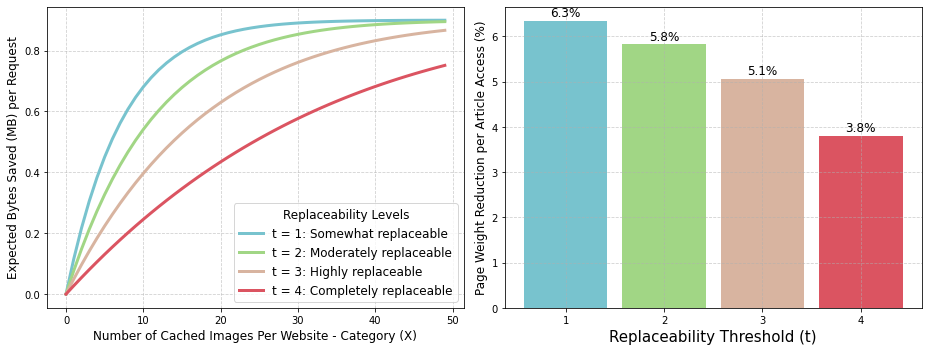

In [46]:
for threshold in threshold_values:
    p_values = []
    bytes_saved_my = []
    bytes_saved_http = []

    u_list = []
    N_list = []

    for df in dfs:
        num_useful_comparisons, total_comparisons = extract_comparisons(df, threshold=threshold)
        u_list.append(num_useful_comparisons)
        N_list.append(total_comparisons)

    u = (sum([u_list[i] / N_list[i] for i in range(len(u_list))]) / len(u_list))
    N = int(sum(N_list) / len(N_list))

    for X in X_vals:
        p = 1 - (comb(int(N * (1 - u)), X) / comb(N, X))
        p_values.append(p)
        bytes_saved_my.append((my_image_size * p) - (hash_size_bytes * X))
        bytes_saved_http.append((http_image_size * p) - (hash_size_bytes * X))

    bytes_saved_values_my = [value / 10**6 for value in bytes_saved_my]
    bytes_saved_values_http = [value / 10**6 for value in bytes_saved_http]

    bytes_saved_values_dict_my[threshold] = bytes_saved_values_my
    bytes_saved_values_dict_http[threshold] = bytes_saved_values_http

    mean_bytes_saved = np.mean(bytes_saved_my)
    percent_saved = (num_images_per_article * mean_bytes_saved) / avg_page_weight
    percent_saved_page_weight[threshold] = percent_saved * 100

fig, axs = plt.subplots(1, 2, figsize=(13, 5))

colors = ['#78C3CE', '#A1D685', '#D8B4A0', '#DB5461']

labels = [
    "t = 1: Somewhat replaceable",
    "t = 2: Moderately replaceable",
    "t = 3: Highly replaceable",
    "t = 4: Completely replaceable"
]

for idx, threshold in enumerate(threshold_values):
    axs[0].plot(X_vals, bytes_saved_values_dict_http[threshold], label=labels[idx], color=colors[idx], linewidth=3)

axs[0].set_xlabel('Number of Cached Images Per Website - Category (X)', fontsize=12)
axs[0].set_ylabel('Expected Bytes Saved (MB) per Request', fontsize=12)
axs[0].legend(title='Replaceability Levels', fontsize=12, title_fontsize=12)
axs[0].grid(True, linestyle='--', alpha=0.6)

thresholds = list(percent_saved_page_weight.keys())
percent_saved = list(percent_saved_page_weight.values())

axs[1].bar(thresholds, percent_saved, color=colors, width=0.85)
for i, value in enumerate(percent_saved):
    axs[1].text(thresholds[i], value + 0.1, f'{value:.1f}%', ha='center', fontsize=12)

axs[1].set_xlabel('Replaceability Threshold (t)', fontsize=15)
axs[1].set_ylabel('Page Weight Reduction per Article Access (%)', fontsize=12)
axs[1].set_xticks(thresholds)
axs[1].grid(True, linestyle='--', alpha=0.6)

plt.subplots_adjust(wspace=0.2)
plt.tight_layout()
plt.show()


In [64]:
stats = {}

for threshold, bytes_saved_values_mb in bytes_saved_values_dict_http.items():
    bytes_saved_array = np.array(bytes_saved_values_mb)

    std_bytes_saved = np.std(bytes_saved_array)

    stats[threshold] = {
        "std": std_bytes_saved,
    }

for threshold, stat in stats.items():
    print(f"Threshold {threshold}:")
    print(f"  Standard Deviation (MB): {stat['std']}")


Threshold 1:
  Standard Deviation (MB): 0.21946890202999872
Threshold 2:
  Standard Deviation (MB): 0.23938221423167938
Threshold 3:
  Standard Deviation (MB): 0.24587862196819216
Threshold 4:
  Standard Deviation (MB): 0.21990399693010784


### Performance Results

#### Confusion Matrix

In [49]:
def load_csv_files(true_file, pred_file):
    true_df = pd.read_csv(true_file, index_col=0)
    pred_df = pd.read_csv(pred_file, index_col=0)
    return true_df, pred_df

In [52]:
def calculate_kappa_and_conf_matrix(true_csv, pred_csv, test_folder):
    true_labels = []
    pred_labels = []

    for website in os.listdir(test_folder):
        website_path = os.path.join(test_folder, website)
        if not os.path.isdir(website_path):
            continue

        for category in os.listdir(website_path):
            category_path = os.path.join(website_path, category)
            if not os.path.isdir(category_path):
                continue

            true_file = os.path.join(category_path, true_csv)
            pred_file = os.path.join(category_path, pred_csv)

            if os.path.exists(true_file) and os.path.exists(pred_file):
                true_df, pred_df = load_csv_files(true_file, pred_file)
                for i in range(true_df.shape[0]):
                    for j in range(i + 1, true_df.shape[1]):
                        true_labels.append(true_df.iloc[i, j])
                        pred_labels.append(pred_df.iloc[i, j])

    true_labels = np.array(true_labels)
    pred_labels = np.array(pred_labels)

    kappa = cohen_kappa_score(true_labels, pred_labels, weights='quadratic')
    conf_matrix = confusion_matrix(true_labels, pred_labels, labels=[0, 1, 2, 3, 4])

    return kappa, conf_matrix

[0.6221856070319773, 0.5041300318074767, 0.42839450488422925, 0.41813793481932093]


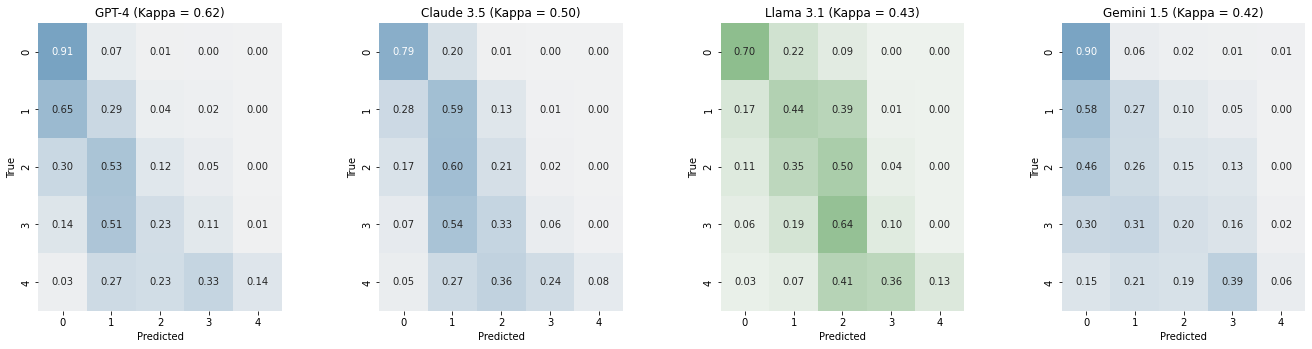

In [60]:
def plot_heatmaps(kappa_values, conf_matrices, models, model_names):
    _, axes = plt.subplots(1, len(models), figsize=(22, 5))

    custom_palette_blues = sns.light_palette("#6d9cbe", as_cmap=True)  
    custom_palette_llama = sns.light_palette("#65a765", as_cmap=True)  

    for i, model in enumerate(models):
        if model == 'llama':
            cmap = custom_palette_llama  
        else:
            cmap = custom_palette_blues 
        
        # Normalize the confusion matrix by row (true labels)
        conf_matrix_normalized = conf_matrices[i].astype('float') / conf_matrices[i].sum(axis=1)[:, np.newaxis]

        sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2f", cmap=cmap, norm=Normalize(vmin=0, vmax=1), 
                    ax=axes[i], xticklabels=[0, 1, 2, 3, 4], yticklabels=[0, 1, 2, 3, 4], cbar=False)
        
        axes[i].set_title(f"{model_names[model]} (Kappa = {kappa_values[i]:.2f})")
        axes[i].set_xlabel("Predicted")
        axes[i].set_ylabel("True")

    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
    plt.show()

kappa_values = []
conf_matrices = []

for model in models:
    kappa, conf_matrix = calculate_kappa_and_conf_matrix(true_csv, f'{model}_pred_labels.csv', data_dir)
    kappa_values.append(kappa)
    conf_matrices.append(conf_matrix)

print(kappa_values)
plot_heatmaps(kappa_values, conf_matrices, models, model_names_mapping)

#### Radar Plot (NRMSE, F1, Precision, Recall, Kappa)

In [86]:
from sklearn.metrics import precision_score, f1_score, recall_score

def calculate_metrics(true_csv, calculate_for, test_folder, websites=None):
    true_labels = []
    pred_labels = []

    website_list = websites if websites else os.listdir(test_folder)

    for website in website_list:
        website_path = os.path.join(test_folder, website)
        if not os.path.isdir(website_path):
            continue

        for category in os.listdir(website_path):
            category_path = os.path.join(website_path, category)
            if not os.path.isdir(category_path):
                continue

            true_file = os.path.join(category_path, true_csv)
            pred_file = os.path.join(category_path, calculate_for)

            if os.path.exists(true_file) and os.path.exists(pred_file):
                true_df, pred_df = load_csv_files(true_file, pred_file)
                true_vals, pred_vals = process_category(true_df, pred_df)

                if true_vals:
                    true_labels.extend(true_vals)  
                    pred_labels.extend(pred_vals)  
    if not true_labels or not pred_labels:
        raise ValueError("No valid data found for calculation.")

    precision = precision_score(true_labels, pred_labels, zero_division=1, average='weighted')
    recall = recall_score(true_labels, pred_labels, zero_division=1, average="weighted")
    f1 = f1_score(true_labels, pred_labels, zero_division=1, average='weighted')

    return {
        "precision": precision,
        "recall": recall,
        "f1_score": f1
    }


##### Weighted precision, recall, f1 score (weighted by class frequency)

In [93]:
print("Gemini 1.5 pro evalution metrics (weighted)")
calculate_metrics(true_csv, calculate_for='gemini_pred_labels.csv', test_folder=data_dir)

Gemini 1.5 pro evalution metrics (weighted)


{'precision': 0.8731454235525763,
 'recall': 0.8234993054032317,
 'f1_score': 0.8458605002172435}

In [92]:
print("LLaMA 3.1 evalution metrics (weighted)")
calculate_metrics(true_csv, calculate_for='llama_pred_labels.csv', test_folder=data_dir)

LLaMA 3.1 evalution metrics (weighted)


{'precision': 0.9108885088397798,
 'recall': 0.6307669810630986,
 'f1_score': 0.7293582526453034}

In [94]:
print("GPT-4o evalution metrics (weighted)")
calculate_metrics(true_csv, calculate_for='gpt_pred_labels.csv', test_folder=data_dir)

GPT-4o evalution metrics (weighted)


{'precision': 0.8375991375146135,
 'recall': 0.7968116347364005,
 'f1_score': 0.8072842869888428}

In [95]:
print("Claude evalution metrics (weighted)")
calculate_metrics(true_csv, calculate_for='claude_pred_labels.csv', test_folder=data_dir)

Claude evalution metrics (weighted)


{'precision': 0.9064924125633398,
 'recall': 0.7203577782652141,
 'f1_score': 0.7900234430698408}

##### NRMSE

In [107]:
pred_csv = {x: f'{x}_pred_labels.csv' for x in models}

nrmse = {}
for model, csv in pred_csv.items():
    nrmse[model] = calculate_rmse(true_csv, pred_csv[model], data_dir, overall=True)

nrmse

{'gpt': 0.1730162550977163,
 'claude': 0.1656214943587613,
 'gemini': 0.19353271594126345,
 'llama': 0.21109073079928872}

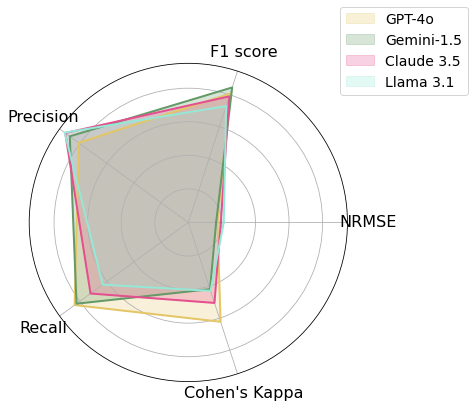

In [108]:
gpt = [0.1730162550977163, 0.807284287, 0.8072560166, 0.8375991375, 0.622185607031977]
gemini = [0.1656214943587613, 0.8458605002172435, 0.8731454235525763, 0.8234993054032317, 0.41813793481932093]
claude = [0.19353271594126345, 0.7900234430698408, 0.9064924125633398, 0.7203577782652141, 0.5041300318074767]
llama = [0.21109073079928872, 0.7293582526453034, 0.9108885088397798, 0.6307669810630986, 0.42839450488422925]

categories = ['NRMSE', 'F1 score', 'Precision', 'Recall', "Cohen's Kappa"]

angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
angles += angles[:1]  

gpt += gpt[:1]
gemini += gemini[:1]
claude += claude[:1]
llama += llama[:1]


def plot_radar():  
    colors = {
    'gpt_color': '#E4C666',  
    'gemini_color': '#639A67',  
    'claude_color': '#E4508F',  
    'llama_color': '#95E8D7'  
    }
    
    plt.rcParams.update({'font.size': 16})  

    fig, ax = plt.subplots(figsize=(7, 7), subplot_kw=dict(polar=True))

    ax.fill(angles, gpt, color=colors['gpt_color'], alpha=0.25, label='GPT-4o')
    ax.plot(angles, gpt, color=colors['gpt_color'], linewidth=2)

    ax.fill(angles, gemini, color=colors['gemini_color'], alpha=0.25, label='Gemini-1.5')
    ax.plot(angles, gemini, color=colors['gemini_color'], linewidth=2)

    ax.fill(angles, claude, color=colors['claude_color'], alpha=0.25, label='Claude 3.5')
    ax.plot(angles, claude, color=colors['claude_color'], linewidth=2)

    ax.fill(angles, llama, color=colors['llama_color'], alpha=0.25, label='Llama 3.1')
    ax.plot(angles, llama, color=colors['llama_color'], linewidth=2)

    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=16, zorder=4)  

    ax.tick_params(axis='x', pad=10)

    ax.legend(loc='upper right', bbox_to_anchor=(1.4, 1.2), fontsize=14)
    plt.tight_layout()
    plt.show()

plot_radar()
